In [73]:
# this cell imports the libraries or packages that you can use during this assignment
# you are not allowed to import additional libraries or packages

from helpers import *
import os
import itertools
import numpy as np
import pandas as pd

# Machine Learning and Decomposition
from sklearn.decomposition import PCA, FastICA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import skfuzzy as fuzz

# Statistical tools
from scipy.stats import multivariate_normal
from scipy import linalg

# Visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.colors import ListedColormap, LogNorm
import seaborn as sns

> **Important**
>
> Do not import any other packages or libraries than the ones already provided to you. You can only use the imported packages _after_ they have been imported.
>
> Write your code between the `BEGIN_TODO` and `END_TODO` markers. Do not change these markers.
>
> Restart your notebook and run all cells before submission.

# Assignment 1a

## Introduction
In this assignment you will carry on data collection and preprocessing tasks, After collecting and preprocessing sensor recording, you will extract a set of features which you will use for creating the biking lane detector in assignment 1b.

This assignment is split into 4 parts. Parts 1-3 encompass the collection, preprocessing and feature extraction of sensor recordings. In part 4 you will employ PCA and ICA for data compression.

### Learning goals
After this assignment you can
- collect data according to a protocol;
- load and merge datasets;
- preprocess data;
- extract features from data;
- Perform data compression

## Part 1: Data collection

Collect the data according to the data collection protocol provided on Canvas.

## Part 2: Data cleaning and preprocessing
In this part you will be working on cleaning and preprocessing the overall data that each group have gathered for further analysis.


---
---
### Exercise 2.1: Read, merge and select data
Place your recordings in folder titled Data, inside the folder, create two folders, Bumpy folder and smooth folder, Load one of your individuals recordings from either folders in a Pandas DataFrame called `data`. You may want to have a look at the `pd.merge_asof` function to combine the recordings of the different sensors. Make sure that the `data` dataframe does not contain any `NaN`'s or empty fields as a result of different sampling frequencies. Any columns/recordings that you will not be using in your experiment should be removed from `data` (except for the `seconds_elapsed` column). Also remove duplicate colums. In the end your dataframe should have an indexing column, a column called `seconds_elapsed`, followed by the columns corresponding to the measurements.

In [41]:
#// BEGIN_TODO  Read, merge and select data

df = pd.read_json('data/smooth/smooth6-12.json')

def select_df(data):
    # Only keeping the recordings for these sensors
    data = data.loc[data['sensor'].isin(['Accelerometer','Gyroscope', 'Gravity'])]

    data = data.pivot_table(index='seconds_elapsed', 
                        columns='sensor', 
                        values=['z', 'y', 'x'])

    # Flatten the multi-level column names created by the pivot
    data.columns = ['_'.join(col).strip() for col in data.columns.values]

    # Only selecting rows without any NaN values in all columns
    data = data[~data.isnull().any(axis=1)]
    
    data.reset_index(inplace=True)
    
    return data

data = select_df(df)
#// END_TODO 

In [42]:
data.shape

(45744, 10)

In [43]:
data.head()

,seconds_elapsed,x_Accelerometer,x_Gravity,x_Gyroscope,y_Accelerometer,y_Gravity,y_Gyroscope,z_Accelerometer,z_Gravity,z_Gyroscope
0,0.011955,-0.496134,0.207184,0.256289,0.450715,-4.147811,-0.093638,0.493838,-8.883869,0.406454
1,0.012641,0.107106,0.610556,0.179300,0.174029,-3.190573,0.191288,0.274286,-9.252991,0.018437
2,0.016803,-0.448700,0.682733,-0.245705,0.128680,-5.679636,0.183460,0.632159,-7.965300,-0.093943
3,0.020426,-0.116088,0.823425,-0.278666,-0.273827,-2.361740,0.112736,0.437932,-9.482328,0.050440
4,0.021958,-0.673067,0.180909,0.414810,0.734110,-4.178619,-0.085691,0.926782,-8.869995,0.461474


### End of exercise 2.1
---
---

In order to restrict our focus to bumpy lane detection, we would like to trim the recorded segment. In this way we can remove the movements corresponding to starting and stopping the sensor logger app. 

---
---
### Exercise 2.2: Trim data
Remove the first and last 5 seconds of the recordings for this purpose and save this trimmed data frame to `data_trimmed`. Make sure that your code works for a data frame containing an arbitrary number of columns.

In [44]:
#// BEGIN_TODO Trim data

def trim_df(data):
    last_time = data["seconds_elapsed"].iloc[-1]
    data = data[(data["seconds_elapsed"] > 5) & (data["seconds_elapsed"] < last_time - 20)]
    return data

data_trimmed = trim_df(data)

#// END_TODO 

In [45]:
data_trimmed.shape

(36849, 10)

In [46]:
data_trimmed.head()

,seconds_elapsed,x_Accelerometer,x_Gravity,x_Gyroscope,y_Accelerometer,y_Gravity,y_Gyroscope,z_Accelerometer,z_Gravity,z_Gyroscope
2990,5.001393,-0.631891,0.656731,-0.161295,-0.740316,8.297913,-0.900749,-0.497536,-5.184952,0.711158
2991,5.002922,0.749503,0.606064,-0.422469,0.068329,8.319756,-1.126441,-0.125272,-5.156037,0.550694
2992,5.003667,-0.366783,-0.594489,0.083113,-1.140310,8.652268,-0.194741,-1.358136,-4.577688,-0.109587
2993,5.003702,1.983834,-2.029174,-0.099861,-0.485201,7.357607,-0.869879,-0.676453,-6.157796,0.634314
2994,5.005944,-0.043548,1.996468,0.003601,-0.572453,8.289115,0.004593,-0.285516,-4.845109,-0.244381


### End of exercise 2.2
---
---

---
---
### Exercise 2.3: Normalize recordings
For improved processing, the recordings should be normalized. Normalize the recordings by subtracting its mean and by then dividing by its standard deviation. Perform this normalization for each column individually. Save your normalized data in the the data frame `data_norm`.

In [47]:
#// BEGIN_TODO Normalize recordings

def normalize_df(data):
    for col in data.columns:
        if col == "seconds_elapsed":
            continue
        data[col] = (data[col] - data[col].mean()) / data[col].std()
    return data
    
data_norm = normalize_df(data_trimmed)
#// END_TODO 

/var/folders/bb/jrtmcq5s0gd1xydt968dvm2r0000gn/T/ipykernel_34325/3006164818.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = (data[col] - data[col].mean()) / data[col].std()


In [48]:
data_norm.shape

(36849, 10)

In [49]:
data_norm.head()

,seconds_elapsed,x_Accelerometer,x_Gravity,x_Gyroscope,y_Accelerometer,y_Gravity,y_Gyroscope,z_Accelerometer,z_Gravity,z_Gyroscope
2990,5.001393,-0.124951,-4.041652,-0.199975,-0.656057,1.558077,-1.018116,-0.350034,-1.030521,0.506098
2991,5.002922,0.210841,-4.073992,-0.488435,-0.276829,1.567928,-1.269033,-0.183766,-1.008204,0.390894
2992,5.003667,-0.060508,-4.840291,0.069966,-0.843641,1.717894,-0.233197,-0.734412,-0.561818,-0.083150
2993,5.003702,0.510885,-5.756034,-0.132123,-0.536416,1.133991,-0.983795,-0.429946,-1.781388,0.450928
2994,5.005944,0.018065,-3.186513,-0.017853,-0.577334,1.554109,-0.011583,-0.255338,-0.768221,-0.179924


### End of exercise 2.3
---
---

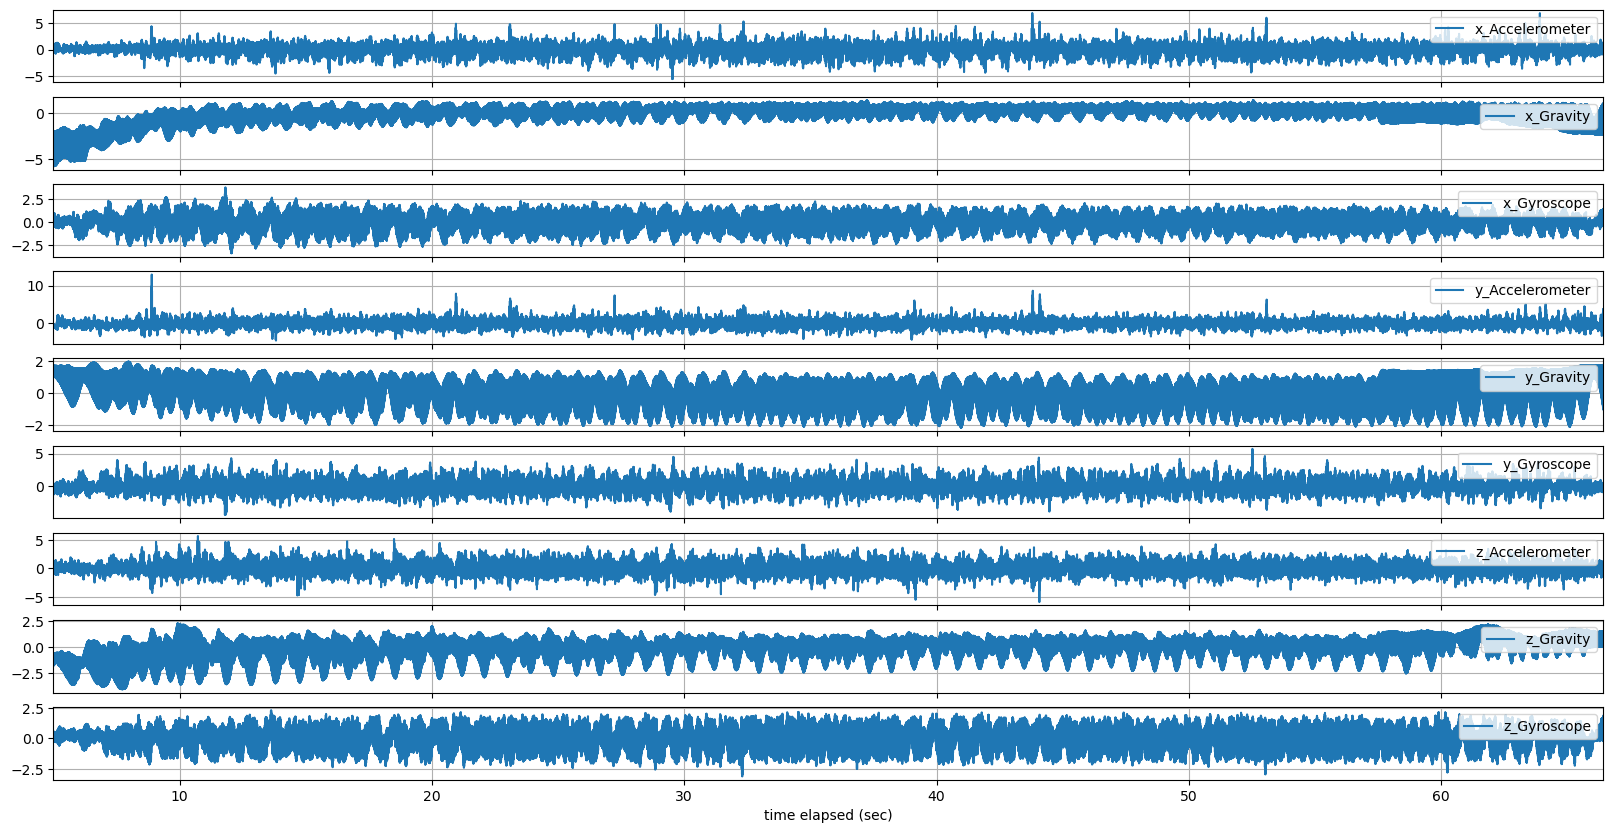

In [50]:
# plot recordings
ex2_plot_data(data_norm)

## Part 3: Feature extraction
The current data is not yet suited for building the detector. Based on the measurements at a specific point of time, it is difficult to determine whether the bike lane is smooth or bumpy. Instead, it would be more appropriate to perform the detection over _segments_ of time. In this part you will extract features that will be used for the detection. First all collected datasets will be processed.

---
---
### Exercise 3.1: Merge all datasets
Before starting the feature extraction, merge all the preprocessed datasets obtained in the protocol. You will need to load all recording, and again perform all preprocessing steps of Part 2 for the individual recordings. Make sure your code adheres to proper coding standards (make it look nice, don't copy part 2 15 times). Save your merged data in the the data frame `data_merged`, in addition, save merged data of bumpy lanes as `data_bumpy` and data of smooth lanes as `data_smooth`.

In [51]:
#// BEGIN_TODO Normalize recordings

# Helper function to load and merge JSON files from a directory
def load_and_process_json_files(directory):
    files = [file for file in os.listdir(directory) if file.endswith(".json")]
    print(f"Loading files from {directory}: {files}")
    data_combined = pd.DataFrame()

    for file in files:
        file_path = os.path.join(directory, file)
        try:
            data = pd.read_json(file_path)
            data_combined = pd.concat([data_combined, data], ignore_index=True)
        except (ValueError, UnicodeDecodeError) as e:
            print(f"Skipping file {file}: {e}")

    return data_combined

# SMOOTH
data_smooth = load_and_process_json_files("data/smooth")
data_smooth = select_df(data_smooth)
data_smooth = trim_df(data_smooth)
data_smooth = normalize_df(data_smooth)

# BUMPY
data_bumpy = load_and_process_json_files("data/bumpy")
data_bumpy = select_df(data_bumpy)
data_bumpy = trim_df(data_bumpy)
data_bumpy = normalize_df(data_bumpy)

# Merge datasets
data_merged = pd.concat([data_smooth, data_bumpy], ignore_index=True)

#// END_TODO


Loading files from data/smooth: ['smooth11-16.json', 'smooth6-12.json']
Loading files from data/bumpy: ['bumpy6-12.json']


In [52]:
data_merged.shape

(110550, 10)

In [53]:
data_bumpy.shape

(36849, 10)

In [54]:
data_smooth.shape

(73701, 10)

In [55]:
data_merged.head()

,seconds_elapsed,x_Accelerometer,x_Gravity,x_Gyroscope,y_Accelerometer,y_Gravity,y_Gyroscope,z_Accelerometer,z_Gravity,z_Gyroscope
0,5.000120,0.097080,-1.530145,-0.281898,-0.691722,1.856232,-0.594244,0.177294,2.507193,-1.657196
1,5.000916,-1.590650,-2.960811,0.801799,-0.420774,1.345566,0.426251,1.971849,0.067609,0.266736
2,5.001393,-0.133731,-1.886042,-0.154596,-0.642348,1.252163,-1.010004,-0.332956,-0.418929,0.538267
3,5.002922,0.265202,-1.905321,-0.377345,-0.286366,1.261756,-1.261405,-0.183910,-0.401803,0.414261
4,5.003667,-0.057171,-2.362119,0.053854,-0.818434,1.407777,-0.223574,-0.677520,-0.059262,-0.096005


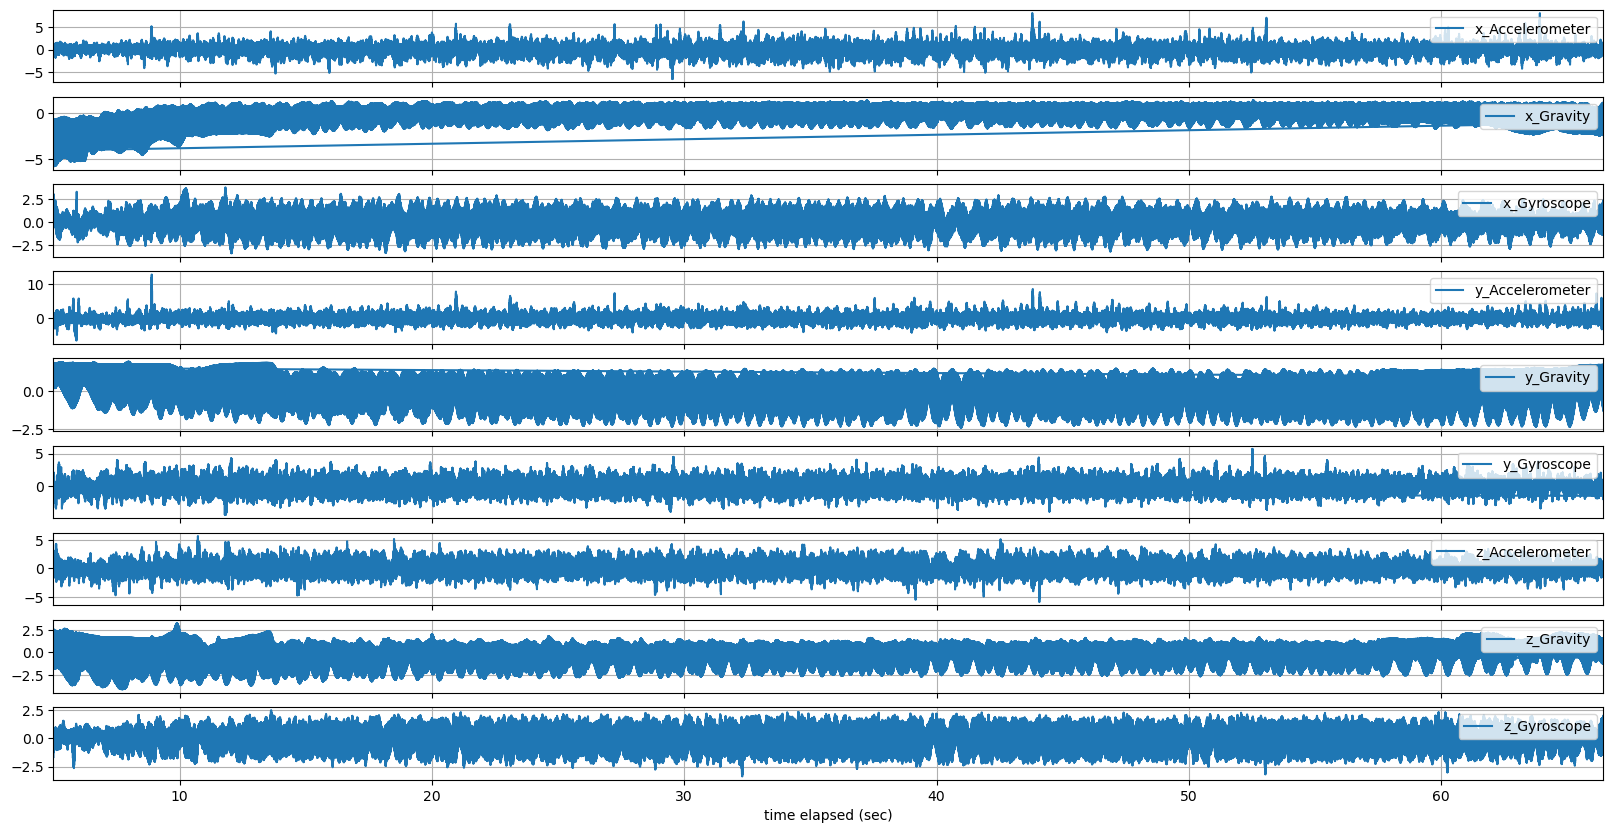

In [56]:
# plot recordings of data_merged
ex2_plot_data(data_merged)

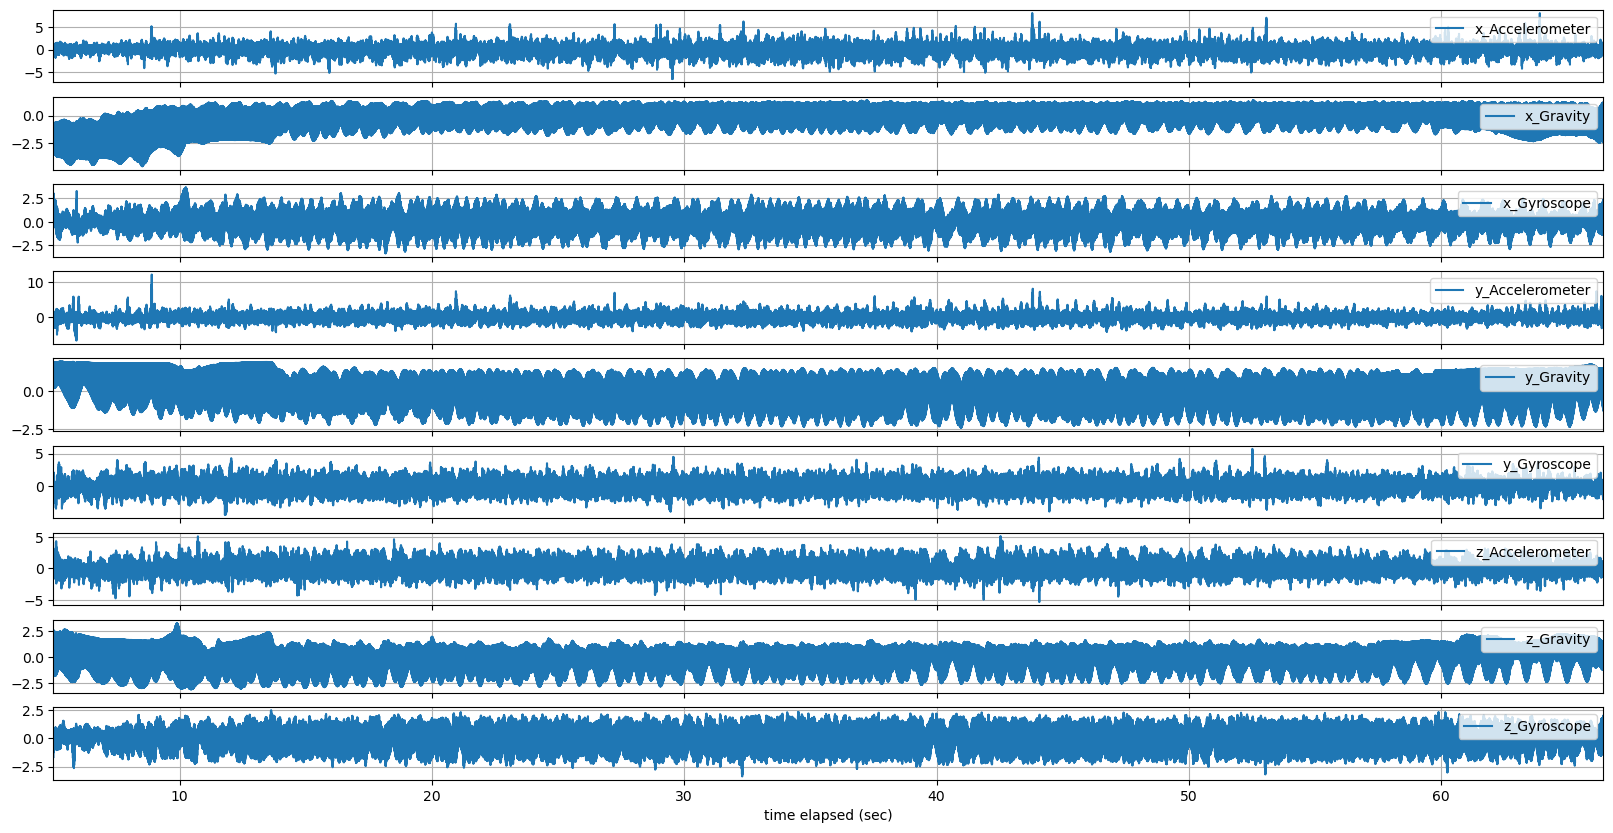

In [57]:
# plot recordings of data_smooth
ex2_plot_data(data_smooth)

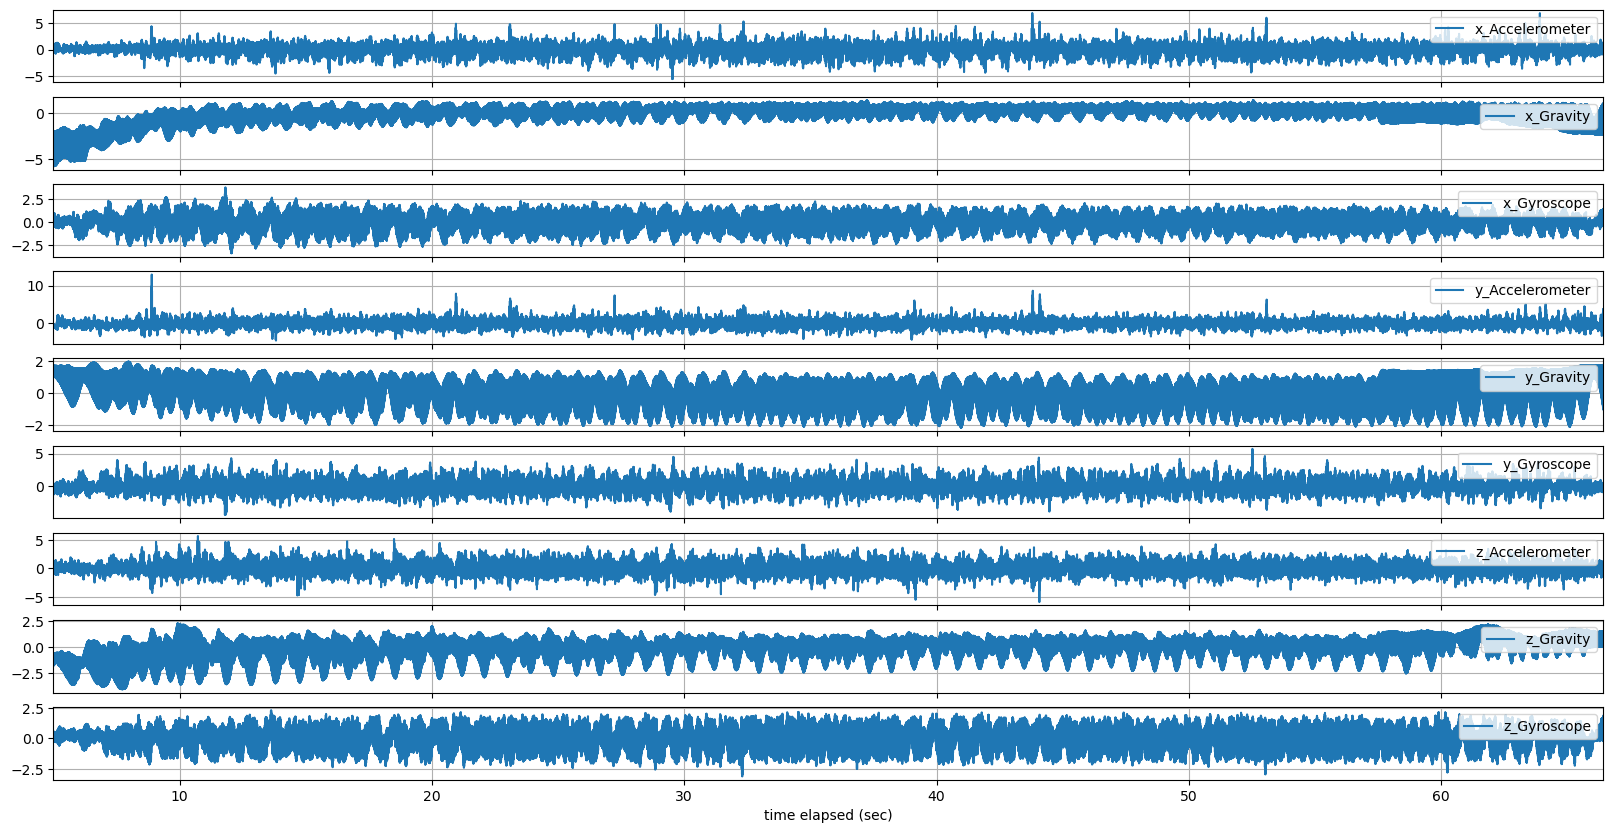

In [58]:
# plot recordings of data_bumpy
ex2_plot_data(data_bumpy)

### End of exercise 3.1
---
---

---
---
### Exercise 3.2: Convert dataframe to matrix
In order to extract features from the recordings, convert the dataframe `data_merged` to a Numpy matrix called `mat_merged`. The matrix should have dimensions (_nr of time points_, _nr or different recordings_). Make sure that you remove the _seconds_elapsed_ column, as this does not yield any useful information for the ;ane detector.

In [59]:
#// BEGIN_TODO  Convert to matrix

mat_merged = data_merged.drop(columns=["seconds_elapsed"]).to_numpy()

#// END_TODO 

### End of exercise 3.2
---
---

Now that the dataframe has been converted to a matrix, it can be split into different overlapping segments, of which we can extract features.

As a starting point we will specify features as the mean value of a segment, its standard deviation, its minimum and its maximum.

---
---
### Exercise 3.3: Processing segments
Create a function `Y = process_segment(mat, fun, L, K)` that processes time segments of your matrix. The argument `fun` specifies the operation to be performed on the segment and its value comes from the set `["mean", "std", "minimum", "maximum"]`. `L` specifies the segment length and `K` specifies the number of samples overlap between segments. The function should return a matrix `Y` with dimensions (_nr of segments_, _nr of different recordings_).

In [60]:
#// BEGIN_TODO Process segments

def process_segment(mat, fun, L, K):
    stride = L - K 
    #segments = (mat.shape[0] - L) // stride + 1
    
    # Store the processed segments
    segment_list = []
    
    for i in range(0, mat.shape[0] - L + 1, stride):
        segment = mat[i:i + L]
        
        if fun == "mean":
            processed_segment = np.mean(segment, axis=0)
        elif fun == "std":
            processed_segment = np.std(segment, axis=0)
        elif fun == "minimum":
            processed_segment = np.min(segment, axis=0)
        elif fun == "maximum":
            processed_segment = np.max(segment, axis=0)
        
        segment_list.append(processed_segment)
    
    return np.array(segment_list)   

#// END_TODO 

In [61]:
Y_mean_1 = process_segment(mat_merged, "mean", 20, 10)
Y_std_1 = process_segment(mat_merged, "std", 20, 10)
Y_minimum_1 = process_segment(mat_merged, "minimum", 20, 10)
Y_maximum_1 = process_segment(mat_merged, "maximum", 20, 10)

### End of exercise 3.3
---
---

---
---
### Exercise 3.4: Concatenate features
Now that you have computed some features of the recordings, it becomes necessary to combine them. Create the matrix `combined_features` which concatenates the above results along the appropriate axis.


In [62]:
#// BEGIN_TODO Concatenate features

features = [Y_mean_1, Y_std_1, Y_minimum_1, Y_maximum_1]

for idx, feature in enumerate(features):
    if idx == 0:
        combined_features = feature
    else:
        combined_features = np.concatenate((combined_features, feature), axis=1)
        
#// END_TODO 

### End of exercise 3.4
---
---

### Exercise 3.5: preprocessing smooth and bumpy dataframes
perform the same preprocessing steps on your smooth and bumpy dataframe. By the end of the exercise you should output two additional matrices; `smooth_features` and `combined_features`

In [63]:
#// BEGIN_TODO Concatenate features

mat_smooth = data_smooth.drop(columns=["seconds_elapsed"]).to_numpy()
mat_bumpy = data_bumpy.drop(columns=["seconds_elapsed"]).to_numpy()

# For smooth data
Y_mean_2 = process_segment(mat_smooth, "mean", 20, 10)
Y_std_2 = process_segment(mat_smooth, "std", 20, 10)
Y_minimum_2 = process_segment(mat_smooth, "minimum", 20, 10)
Y_maximum_2 = process_segment(mat_smooth, "maximum", 20, 10)

smooth_features_list = [Y_mean_2, Y_std_2, Y_minimum_2, Y_maximum_2]

for idx, feature in enumerate(smooth_features_list):
    if idx == 0:
        smooth_features = feature
    else:
        smooth_features = np.concatenate((smooth_features, feature), axis=1)

# For bumpy data
Y_mean_3 = process_segment(mat_bumpy, "mean", 20, 10)
Y_std_3 = process_segment(mat_bumpy, "std", 20, 10)
Y_minimum_3 = process_segment(mat_bumpy, "minimum", 20, 10)
Y_maximum_3 = process_segment(mat_bumpy, "maximum", 20, 10)

bumpy_features_list = [Y_mean_3, Y_std_3, Y_minimum_3, Y_maximum_3]

for idx, feature in enumerate(bumpy_features_list):
    if idx == 0:
        bumpy_features = feature
    else:
        bumpy_features = np.concatenate((bumpy_features, feature), axis=1)


#// END_TODO 

In [75]:
pd.DataFrame(smooth_features).to_csv("debug_output/smooth_features_debug.csv", index=False)
pd.DataFrame(bumpy_features).to_csv("debug_output/bumpy_features_debug.csv", index=False)
pd.DataFrame(combined_features).to_csv("debug_output/combined_features_debug.csv", index=False)

In [64]:
print("Dimensions of combined features:", combined_features.shape)
print("Dimensions of smooth features:", smooth_features.shape)
print("Dimensions of bumpy features:", bumpy_features.shape)

Dimensions of combined features: (11054, 36)
Dimensions of smooth features: (7369, 36)
Dimensions of bumpy features: (3683, 36)


### End of exercise 3.5
---
---

## Part 4: Data Compression
In this part of the assignment you will implement the data compression techniques you have learned during the course.

## Part 4.1: Principal component analysis

Recorded data is often high-dimensional, leading to a large computational burden and limiting real-time data processing. Quite often we would therefore like to compress the data, such that it uses less memory. The creation of .zip-files on your computer is an example of data compression. In this part we will look at one method that achieves data compression, namely Principal component analysis (PCA). PCA is a useful technique for analyzing high-dimensional data, and compressing this data for storage or processing purposes. PCA aims to fit an orthogonal coordinate system to a dataset that best captures the variance or spread of the data. This approach is very closely related to the eigendecomposition of a matrix.

PCA aims to find the orthogonal directions of most variance of the dataset. Therefore it first computes the covariance matrix of the dataset, which can be estimated as
$$\Sigma = \mathrm{Cov}[{\bf{x}}] \approx \frac{1}{N-1} \sum_{n=1}^N ({\bf{x}}_n - \mathrm{E}[{\bf{x}}])({\bf{x}}_n - \mathrm{E}[{\bf{x}}])^\top,$$
where ${\bf{x}}_n$ is the $n$-th data sample and where $\mathrm{E}[{\bf{x}}]$ represents the expected value, or mean, which can be estimated as
$$\mathrm{E}[{\bf{x}}] \approx \frac{1}{N} \sum_{n=1}^N {\bf{x}}_n.$$
The covariance matrix captures the variances of the individual elements/features in ${\bf{x}}_n$ and the covariances between elements/features. 

Based on the obtained covariance matrix, you will perform an eigendecomposition. An eigenvalue decomposition finds a set of eigenvectors and corresponding eigenvalues. An eigenvector ${\bf{v}}$ and corresponding eigenvalue ${\lambda}$ of some square matrix $A$ satisfy the equation
$$A {\bf{v}} = \lambda {\bf{v}}.$$
In matrix notation, this can be written as
$$A Q = Q\Lambda,$$
where $Q$ is an orthonormal matrix where each column represents an eigenvector. Orthonormal refers to the individual eigenvectors being of unit length, and perpendicular to eachother. This matrix satisfies the useful properties $QQ^\top = Q^\top Q = I$ and $Q^\top = Q^{-1}$. $\Lambda$ is a diagonal matrix, whose diagonal contains the eigenvalues of $A$. The matrix $A$ can therefore be decomposed as 
$$A = Q\Lambda Q^\top$$

---
---
### Exercise 4.1: Compute eigenvalues and eigenvectors


Write a function `compute_eigen(X)` which computes the eigenvalues and eigenvectors of the covariance matrix of some toy dataset `X`. The dataset is a matrix of shape ($N\times M$), where $N$ denotes the number of data samples and $M$ the dimensionality of the features. The function should return a vector of length $M$ containing the eigenvalues and a matrix of shape ($M\times M$) containing the corresponding eigenvectors.

In [65]:
#// BEGIN_TODO Compute eigenvalues and eigenvectors

def compute_eigen(X):
    Z = np.cov(X, rowvar=False) # So that each column represents a variable, giving an MxM matrix
    eigenvalues, eigenvectors = np.linalg.eig(Z)
    return eigenvalues, eigenvectors

#// END_TODO 

(array([9.77025285, 0.96928223]),
 array([[ 0.86662217,  0.49896494],
        [-0.49896494,  0.86662217]]))

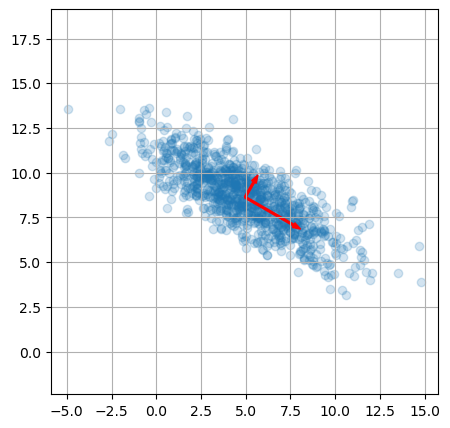

In [66]:
# generate data
X = ex11_generate_data()

# compute eigenvalues and eigenvectors
eigvals, eigvecs = compute_eigen(X)

# plot data
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], alpha=0.2)
plot_eigen(np.mean(X, axis=0), eigvals, eigvecs, plt.gca(), width=0.1, color="r")
plt.axis("equal")
plt.grid()

# print eigenvalues and eigenvectors
eigvals, eigvecs

Have a look at the computed eigenvalues, eigenvectors and the visualization and answer the questions below:
- In what direction does the first eigenvector point?
- How can the eigenvalue be interpreted?

`BEGIN_TODO Interpretation of eigenvalues and eigenvectors`

Answer: The first eigenvector is pointed to the right (the longest arrow). As the first principal component represents the maximum variance direction in the data and the first eigenvector corresponds to this, this makes sense. As for the eigenvalues, these represent the total variance that can be explained by a given principal component. The eigenvalues are 10.2121376 and 0.99607996, meaning that the first principal component explains 10.2121376 units of variance and the second explains 0.99607996 units of variance. 


`END_TODO `

### End of exercise 4.1
---
---

With the computed eigendecomposition, the original dataset can be transformed such that its new mean coincides with the origin (0,0) and that the new eigenvectors specify Euclidean standard basis vectors (i.e. the new covariance matrix is diagonal). The first step can be obtained by subtracting the mean from the dataset. The origin-centered dataset $\tilde{X}$ now is centered in the origin and therefore the covariance matrix can be estimated as 
$$ \tilde{\Sigma} = \mathrm{Cov}[\tilde{\bf{x}}] \approx \frac{1}{N-1} \tilde{X}^\top \tilde{X}\qquad\qquad \text{if }\mathrm{E}[\tilde{{\bf{x}}}] = {\bf{0}}$$
with the corresponding eigendecomposition $\tilde{\Sigma} = \tilde{Q} \tilde{\Lambda} \tilde{Q}^\top$.

If we multiply $\tilde{X}$ with $\tilde{Q}$ to get the transformed dataset $Y=\tilde{X}\tilde{Q}$, we observe that the new covariance matrix becomes
$$\mathrm{Cov}[{\bf{y}}] \approx \frac{1}{N-1} Y^\top Y = \frac{1}{N-1}\tilde{Q}^\top \tilde{X}^\top \tilde{X} \tilde{Q} = \tilde{Q}^\top\tilde{\Sigma}\tilde{Q} = \tilde{Q}^\top\tilde{Q} \tilde{\Lambda} \tilde{Q}^\top\tilde{Q} = \tilde{\Lambda},$$
which is diagonal.



---
---
### Exercise 4.2: Data transformation

Write a function `transform_PCA(X, mean, eigvecs)` which translates some dataset `X` to be centered in the origin, and rotates it, such that its new covariance matrix is diagonal. $X$ is of shape ($N\times M$), where $N$ denotes the number of data samples and $M$ the dimensionality of the features. The function should return the transformed dataset of shape ($N\times M$). Also create the function `inversetransform_PCA(X, mean, eigvecs)` which performs the inverse transform.

In [67]:
#// BEGIN_TODO Transform data to PCA space

def transform_PCA(X, mean, eigvecs):
    X_centered = X - mean
    # Multiplying by eigenvector matrix rotates it into PCA space, making the cov matrix diagonal and thus the PCs uncorrelated
    X_rotated = np.dot(X_centered, eigvecs)
    return X_rotated

#// END_TODO 

In [68]:
#// BEGIN_TODO Transform data back from PCA space

def inversetransform_PCA(X, mean, eigvecs):
    X_inverse_rotate = np.dot(X, eigvecs.T) # Multiplying by the transpose of eigenvectors gives this rotate back effect
    X_original = X_inverse_rotate + mean
    return X_original
    
#// END_TODO

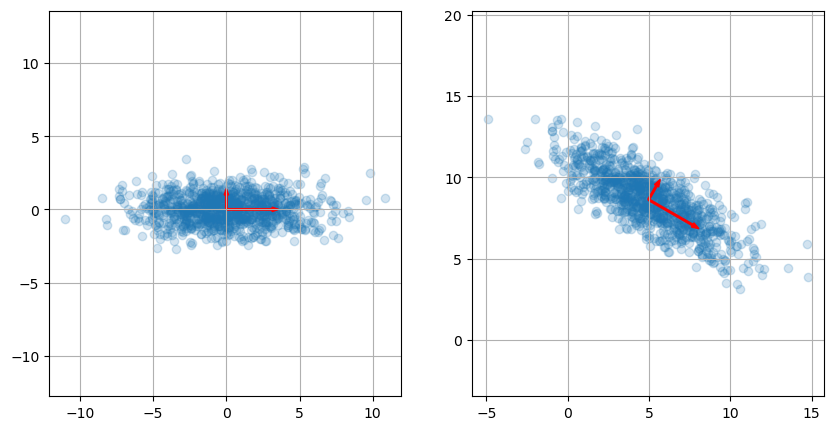

In [69]:
# transform data
m = np.mean(X, axis=0)
eigvals, eigvecs = compute_eigen(X)
Y = transform_PCA(X, m, eigvecs)
Z = inversetransform_PCA(Y, m, eigvecs)

# plot transformed data
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
ax[0].scatter(Y[:,0], Y[:,1], alpha=0.2)
eigvalsY, eigvecsY = compute_eigen(Y)
plot_eigen(np.mean(Y, axis=0), eigvalsY, eigvecsY, ax[0], width=0.1, color="r")
ax[1].scatter(Z[:,0], Z[:,1], alpha=0.2)
eigvalsZ, eigvecsZ = compute_eigen(Z)
plot_eigen(np.mean(Z, axis=0), eigvalsZ, eigvecsZ, ax[1], width=0.1, color="r")
ax[0].axis("equal"), ax[1].axis("equal")
ax[0].grid(), ax[1].grid();

### End of exercise 4.2
---
---

So far PCA has only been discussed for a toy example. Let's now apply it to high-dimensional data. We will load a dataset containing 400 images of faces. These grayscale images are of size (64 $\times$ 64) and therefore contain 4096 pixels. In order to process the images, they have been flattened into vectors, which are appended to create a matrix containing 400 images. Below we have plotted the first 100 images:

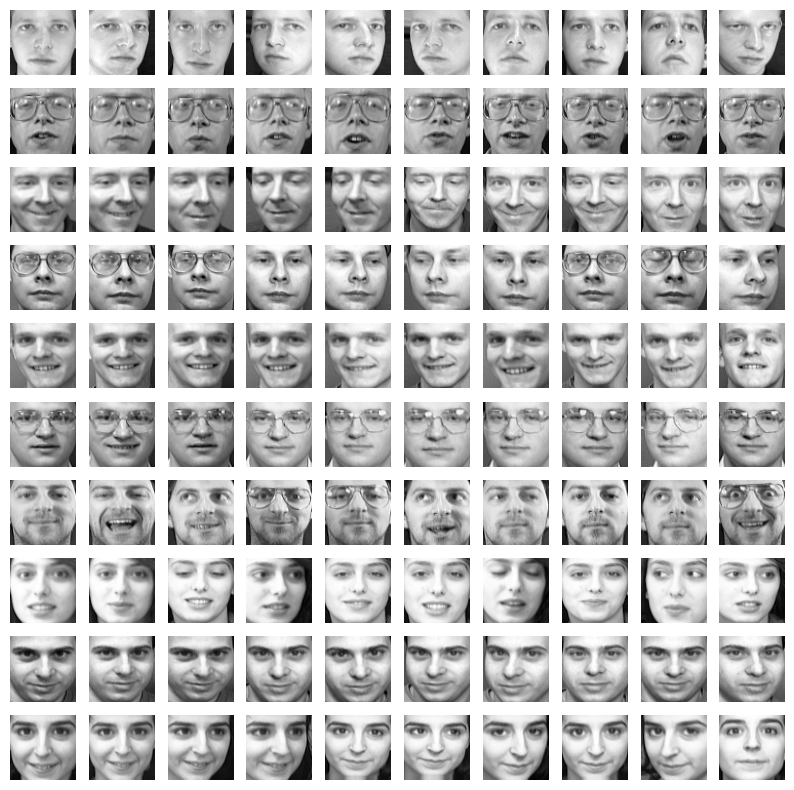

In [70]:
X = ex13_generate_data()
plot_faces(X)

---
---
### Exercise 4.3: Principal components analysis
Compute the eigenvalues and vectors of the faces dataset. Plot the first 350 eigenvalues with both a normal as log-scaling on the y-axis.

> Note: Since the dataset only contains 400 images, the covariance matrix of size (4096 $\times$ 4096) is not positive definite (although it should be in theory). Therefore the eigenvalues > 400 are basically useless, however, they are still computed as imaginary quantities. You can plot the real or absolute values of the eigenvalues.

/Users/jakubfrydrych/anaconda3/envs/Environment-5ARB0/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


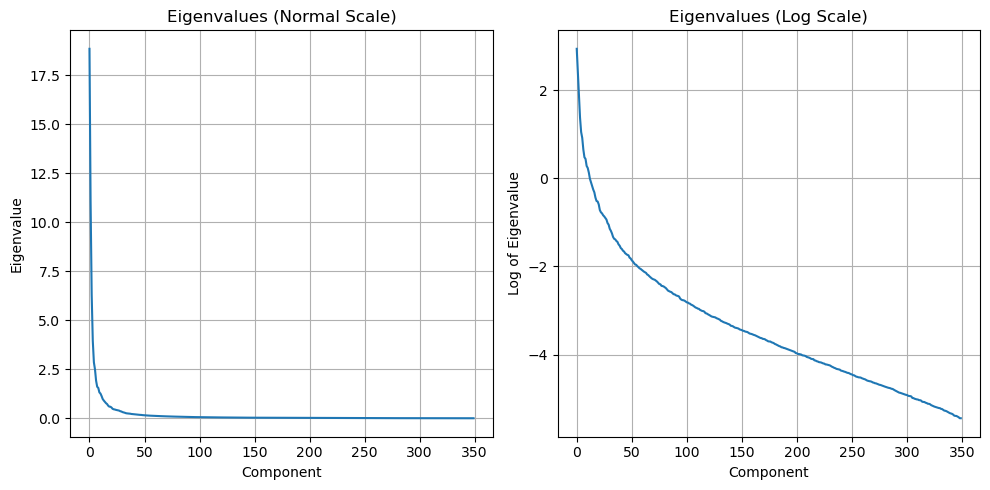

In [71]:
#// BEGIN_TODO Plot eigenvalues

def calculate_eig(X):
    X_centered = X - np.mean(X, axis=0)
    X_cov = np.cov(X_centered, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eig(X_cov)
    
    # As np.linalg.eig does not have the eigenvalues necessarily ordered
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    
    return eigenvalues, eigenvectors

eigenvals, eigenvecs = calculate_eig(X)

plt.figure(figsize=(10, 5))
# Plot eigenvalues with normal scale
plt.subplot(1, 2, 1)
plt.plot(eigenvals[:350], label='Eigenvalues')
plt.title('Eigenvalues (Normal Scale)')
plt.xlabel('Component')
plt.ylabel('Eigenvalue')
plt.grid(True)

# Plot eigenvalues with log scale
plt.subplot(1, 2, 2)
plt.plot(np.log(np.abs(eigenvals[:350])), label='Eigenvalues')
plt.title('Eigenvalues (Log Scale)')
plt.xlabel('Component')
plt.ylabel('Log of Eigenvalue')
plt.grid(True)

plt.tight_layout()
plt.show()


#// END_TODO 

Based on the created plots, what do you observe? How could this be useful for data compression?

`#// BEGIN_TODO  What do you observe?`

In the normal scale plot, the eigenvalues drop off massively after the first few components and beyond that, the eigenvalues become quite small which suggest that the remaining components explain very little variance. In the log scale plot however, we get a clearer view of the smaller eigenvalues. It shows that these components explain some variance, but these decrease quickly. This is useful for data compression as we could effectively represent the data using only the first 50-100 principal components and the rest can be ignored as the additional variance explained by further components is minimal. This can significantly reduce the dimensionality of the data.

`#// END_TODO`

### End of exercise 4.3
---
---

Now we will use PCA for data compression. Instead of performing the transform to the PCA space with the entire eigenvector matrix with shape (4096 $\times$ 4096), we only use the $K$ eigenvectors corresponding with the $K$ largest eigenvalues. 

---
---
### Exercise 4.4: Data compression
Compress the faces dataset using PCA in a matrix of shape (400 $\times$ $K$) and then decompress the data and plot the faces using the `plot_faces()` function. 

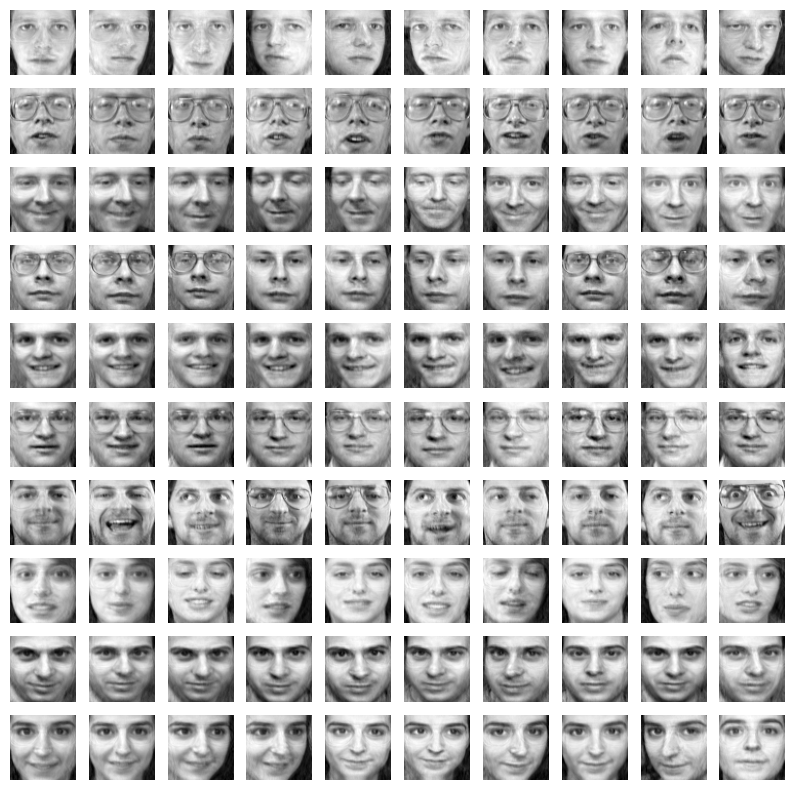

In [72]:
#// BEGIN_TODO Data compression

K = 150 # Can adjust this
m = np.mean(X, axis=0)

X_cov = np.cov(X, rowvar=False)
eigenvalues, eigenvectors = np.linalg.eig(X_cov)

sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

k_eigenvectors = eigenvectors[:,:K]
Y = transform_PCA(X, m, k_eigenvectors) # 400 x K matrix
Z = inversetransform_PCA(Y, m, k_eigenvectors) # Back to 400 x 4096 matrix

plot_faces(Z)


#// END_TODO

Analyze the results. What do you observe if you change $K$?

`#// BEGIN_TODO What do you observe?`

As K increases, the quality of the images relative to the original images improve. The reason for this, the more principal components that are kept, the more of the original variance in the data is captured.

`#// END_TODO`

### End of exercise 4.4
---
---

---
---
### Exercise 4.5: PCA implementation on biking data
During this part you can make use of the sklearn (Scikit learn) package. This package offers some benefits over the handwritten clustering functions. These algorithms are numerically stable and better optimized to run on large data sets. choose 2 principal components for this exercise. Store the compressed data of combined_features as pca_combined, store the compressed data for smooth_features as pca_smooth, store the compressed data for bumpy features as pca_bumpy.

In [34]:
#// BEGIN_TODO PCA with sklearn

pca = PCA(n_components=2)
pca_combined = pca.fit_transform(combined_features)
pca_smooth = pca.fit_transform(smooth_features)
pca_bumpy = pca.fit_transform(bumpy_features)

#// END_TODO 

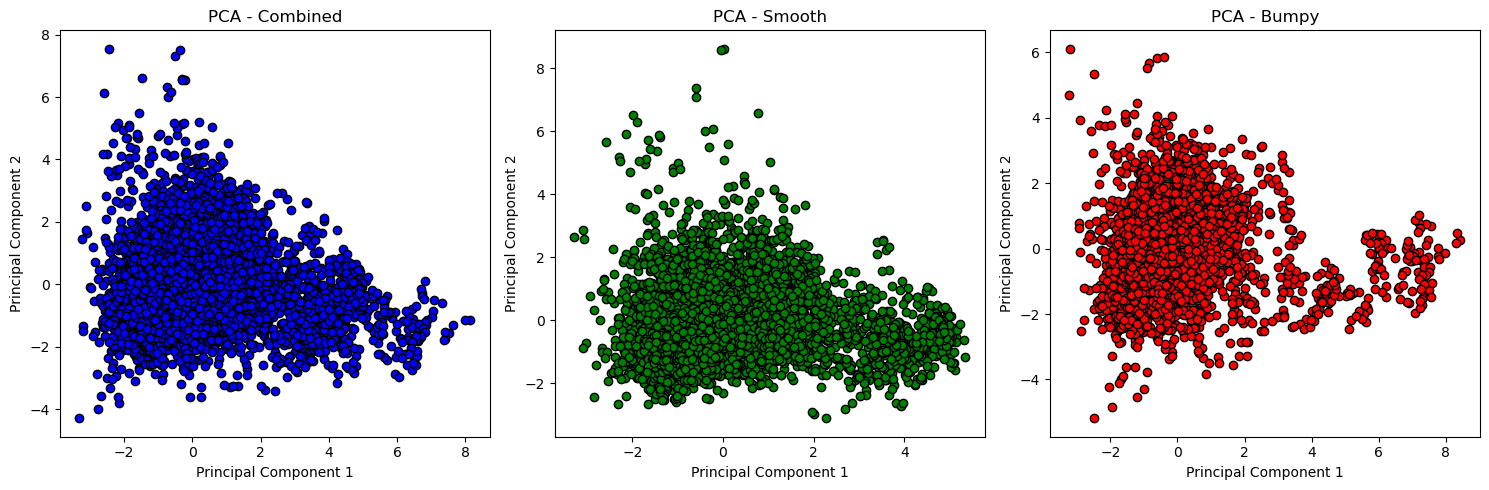

In [35]:

# Create a figure with 3 subplots in a single row
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot PCA for combined features
axs[0].scatter(pca_combined[:, 0], pca_combined[:, 1], c='blue', edgecolor='k')
axs[0].set_title('PCA - Combined')
axs[0].set_xlabel('Principal Component 1')
axs[0].set_ylabel('Principal Component 2')

# Plot PCA for smooth features
axs[1].scatter(pca_smooth[:, 0], pca_smooth[:, 1], c='green', edgecolor='k')
axs[1].set_title('PCA - Smooth')
axs[1].set_xlabel('Principal Component 1')
axs[1].set_ylabel('Principal Component 2')

# Plot PCA for bumpy features
axs[2].scatter(pca_bumpy[:, 0], pca_bumpy[:, 1], c='red', edgecolor='k')
axs[2].set_title('PCA - Bumpy')
axs[2].set_xlabel('Principal Component 1')
axs[2].set_ylabel('Principal Component 2')

# Adjust layout so plots don’t overlap
plt.tight_layout()

# Show the plots
plt.show()


Although we are choosing 2 components, how many principal components would you consider? Justify your answer quantitatively and qualitatively.

`#// BEGIN_TODO  PCA with sklearn/qualitative`

Qualitatively, it seems like looking at the plots a lot of the variance could be captured by the first 2 components. Patterns are formed (such as two clear clusters for the bumpy data and one compact central cluster for the smooth data) and there is no excessive overlap to be seen. The spread seems to also be captured well. However, this could be a case of reducing the dimensionality too much could lead to losing a lot of subtle patterns and there could be components that still explain significant variance. So it is hard to say explicitly that 2 is enough by just looking at the plots. For example, the combined scatter plot shows a dense core but there is a lot of scatter. Additional components could help explain this better. Quantitative analysis is needed for further understanding before making a choice

`#// END_TODO`

In [36]:
#// BEGIN_TODO  PCA with sklearn/quantitative

def pca_component_choice(data):
    pca = PCA()
    pca.fit(data)
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
    n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

    return f'Number of components for 90-95% variance: {n_components_90}-{n_components_95}'
    
print(f"Smooth data --> {pca_component_choice(smooth_features)}")
print(f"Bumpy data --> {pca_component_choice(bumpy_features)}")
print(f"Compressed data --> {pca_component_choice(combined_features)}")

# It would then be justified to consider around 12 to 15 principal components based on this quantitative analysis as the first 12-15 PCs explain cumulatively around 90-95% of the variance in the data for all compressed 
# datasets: (combined, bumpy and smooth)

#// END_TODO


Smooth data --> Number of components for 90-95% variance: 13-16
Bumpy data --> Number of components for 90-95% variance: 12-15
Compressed data --> Number of components for 90-95% variance: 13-16


### End of exercise 4.5
---
---

## Part 4.2: Independent component analysis

Another approach of finding the most important components in a dataset is independent component analysis (ICA). Below you will use it to analyze a toy data set.

---
---
### Exercise 4.6: Limitations PCA
Have a look at the dataset below. Would PCA be a good approach for finding the components of highest variance? Please motivate your answer.

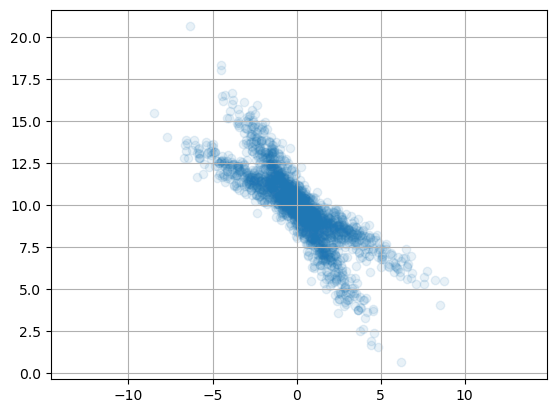

In [37]:
X = ex21_generate_data()
plt.scatter(X[:,0], X[:,1], alpha=0.1)
plt.grid(True)
plt.axis("equal");

`#// BEGIN_TODO Limitations PCA`

PCA may not be the best approach here as it focuses on finding directions of maximum variance, assuming that these directions capture the most important structures in the data. But, PCA is a linear method and relies on cpaturing variance along orthogonal axes and therefore only captures linear variance. We can observe here a complex non-linear pattern between the two variables and PCA would fail to capture this as it would identify components that do not reflect the true nonlinear dependency, like maximizing variance along the most spread-out direction.

`#// END_TODO`

### End of exercise 4.6
---
---

> Note: From this moment onwards you can use the `FastICA` function from `sklearn`.

---
---
### Exercise 4.7: PCA versus ICA
Use the `PCA` and `FastICA` functions from `sklearn` to create the objects `pca_object` and `ica_object`, each with two components. Fit these objects to the dataset and transform the dataset. Save the transformed dataset into the variables `data_transformed_pca` and `data_transformed_ica`.

In [38]:
#// BEGIN_TODO PCA and ICA

pca_object = PCA(n_components=2)
data_transformed_pca = pca_object.fit_transform(X)

ica_object = FastICA(n_components=2)
data_transformed_ica = ica_object.fit_transform(X)

#// END_TODO

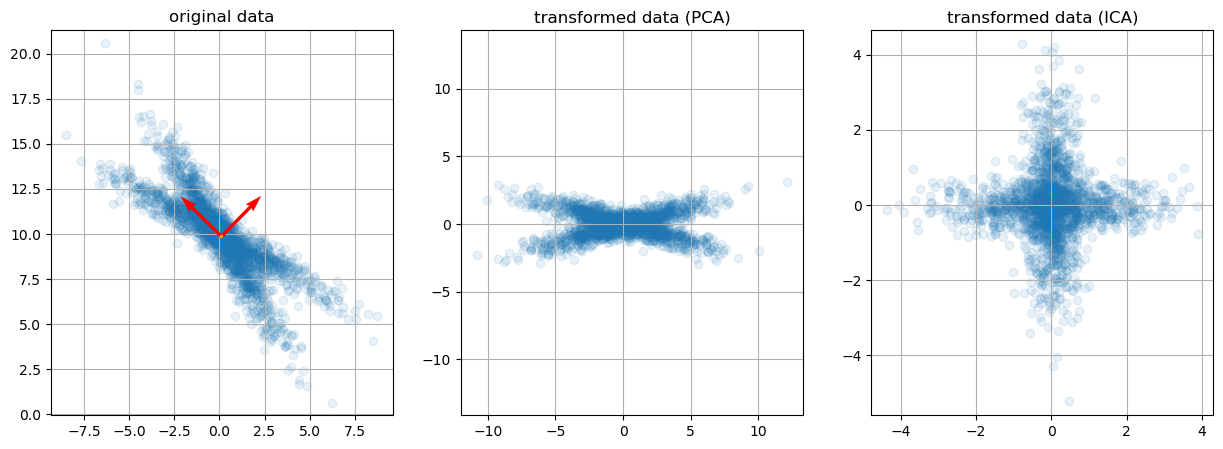

In [39]:
_, ax = plt.subplots(ncols=3, figsize=(15,5))
ax[0].scatter(X[:,0], X[:,1], alpha=0.1)
ax[1].scatter(data_transformed_pca[:,0], data_transformed_pca[:,1], alpha=0.1)
ax[2].scatter(data_transformed_ica[:,0], data_transformed_ica[:,1], alpha=0.1)
plot_pca(ax[0], pca_object, np.mean(X, axis=0))
plot_ica(ax[0], ica_object, np.mean(X, axis=0))
ax[0].grid(True), ax[1].grid(True), ax[2].grid(True)
ax[0].axis('equal'), ax[1].axis('equal'), ax[2].axis('equal')
ax[0].set_title("original data"), ax[1].set_title("transformed data (PCA)"), ax[2].set_title("transformed data (ICA)");

Run your code a couple of times. What do you observe? Which method works best for this data set?

`#// BEGIN_TODO PCA versus ICA`

After re-running the code a few times, it was clear to see that PCA produces consistent results whereas ICA produces different plots each time. This is due to how PCA and ICA work. PCA transforms the data by aligning the PCs with the directions of maximum variance, whereas ICA focuses on finding statistically independent components and those do not necessarily align with maximum variance directions. ICA can be sensitive to random initialization so that explains the constant changes with each re-run. As for which method works the best for this data set, ICA performs better as it transforms the data in a way that tries to make the outputs statistically independent from one another (the cross-shape in the plot on the right). It therefore preserves and highlights the independent structure of the original data set, whereas the distinctness of the independent structures are lost with PCA as it just aligns the data along the direction of maximum variance.

`#// END_TODO`

### End of exercise 4.7
---
---

> Make sure to restart this notebook and to rerun all cells before submission to check whether all code runs properly.

# End of Assignment 1a

---
---
---